<a href="https://colab.research.google.com/github/AlexandreAdam/ExoRIM/blob/dev/notebooks/ExoGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/AlexandreAdam/ExoRIM.git
%cd ExoRIM
!git checkout dev

Cloning into 'ExoRIM'...
remote: Enumerating objects: 341, done.
remote: Counting objects: 100% (341/341), done.
remote: Compressing objects: 100% (254/254), done.
remote: Total 976 (delta 203), reused 206 (delta 86), pack-reused 635
Receiving objects: 100% (976/976), 20.30 MiB | 34.65 MiB/s, done.
Resolving deltas: 100% (594/594), done.
/content/ExoRIM
Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'


In [2]:
# wanb login
%pip install wandb -q
%pip install tensorflow_addons
import wandb

     |████████████████████████████████| 2.0MB 18.0MB/s 
     |████████████████████████████████| 133kB 57.0MB/s 
     |████████████████████████████████| 163kB 54.6MB/s 
     |████████████████████████████████| 102kB 12.8MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
     |████████████████████████████████| 706kB 21.3MB/s 


In [3]:
from ExoRIM import PhysicalModel
from ExoRIM.simulated_data import CenteredBinaries 
from ExoRIM.definitions import dtype
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import ExoRIM.log_likelihood as chisq
import tensorflow as tf

os.mkdir("logs")

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [71]:
class LinearProjection(tf.keras.layers.Layer):
    def __init__(self, num_outputs, name="linear_projection"):
        super(LinearProjection, self).__init__(name=name)
        self.num_outputs = num_outputs

    def build(self, input_shape):
        self.matrix = self.add_weight("matrix", shape=[int(input_shape[-1]), self.num_outputs], 
                                      initializer=tf.keras.initializers.random_normal())

    def call(self, input):
        return tf.einsum("...i, ij -> ...j", input, self.matrix)

In [72]:
def generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(10,)))
    model.add(LinearProjection(16)) # linear projection to a square 4x4 image
    model.add(tf.keras.layers.Reshape((4, 4, 1)))
    #block 1
    model.add(tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=1, strides=2, padding="same", activation="relu"))
    model.add(tf.keras.layers.BatchNormalization())
    #block 2
    model.add(tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding="same", activation="relu"))
    model.add(tf.keras.layers.BatchNormalization())
    # block 3
    model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding="same", activation="relu"))
    model.add(tf.keras.layers.BatchNormalization())
    #final layer (None, 64, 64, 1)
    model.add(tf.keras.layers.Conv2DTranspose(filters=1,   kernel_size=5, strides=2, padding="same", activation="tanh"))

    return model
gen = generator()
gen.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
linear_projection (LinearPro (None, 16)                160       
_________________________________________________________________
reshape_40 (Reshape)         (None, 4, 4, 1)           0         
_________________________________________________________________
conv2d_transpose_72 (Conv2DT (None, 8, 8, 512)         1024      
_________________________________________________________________
batch_normalization_142 (Bat (None, 8, 8, 512)         2048      
_________________________________________________________________
conv2d_transpose_73 (Conv2DT (None, 16, 16, 256)       3277056   
_________________________________________________________________
batch_normalization_143 (Bat (None, 16, 16, 256)       1024      
_________________________________________________________________
conv2d_transpose_74 (Conv2DT (None, 32, 32, 128)     

In [73]:
def discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(64, 64, 1)))
    #block 1
    model.add(tf.keras.layers.Conv2D(filters=54, kernel_size=5, strides=2, padding="same"))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization())
    #block 2
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=5, strides=2, padding="same"))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization())
    #block 3
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=5, strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=5, strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization())


    model.add(tf.keras.layers.Reshape((-1,)))
    model.add(LinearProjection(2))
    model.add(tf.keras.layers.Activation("sigmoid"))

    return model

D = discriminator()
D.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 32, 32, 54)        1404      
_________________________________________________________________
leaky_re_lu_88 (LeakyReLU)   (None, 32, 32, 54)        0         
_________________________________________________________________
batch_normalization_145 (Bat (None, 32, 32, 54)        216       
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 16, 16, 128)       172928    
_________________________________________________________________
leaky_re_lu_89 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
batch_normalization_146 (Bat (None, 16, 16, 128)       512       
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 8, 8, 256)       

In [74]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, total_items, batch_size):
        self.total_items = total_items
        self.batch_size = batch_size
        self.indices = tf.range(batch_size)

    def __len__(self):
        return self.total_items // self.batch_size

    def __getitem__(self, idx):
        return self.generate_batch()

    @staticmethod
    def normalize(X, xmin, xmax):
        return 2 * (X - xmin) / (xmax - xmin) - 1 # return x in [-1, 1]

    def generate_batch(self):
        X1 = CenteredBinaries(self.batch_size//2, 64, width=5).generate_epoch_images()
        X1 = tf.constant(X1, tf.float32)
        xmax = tf.reduce_max(X1)
        X01 = tf.random.uniform(shape=[self.batch_size//4, 64, 64, 1], maxval=xmax)
        X02 = tf.zeros(shape=[self.batch_size//8, 64, 64, 1])
        X03 = tf.ones(shape=[self.batch_size//8, 64, 64, 1]) * np.random.uniform(0, xmax)
        X = tf.concat([X01, X02, X03, X1], axis=0)
        Y = tf.concat([tf.ones(shape=self.batch_size//2), tf.zeros(shape=self.batch_size//2)], axis=0)
        Y = tf.cast(Y, tf.int32)
        Y = tf.one_hot(Y, depth=2, axis=-1)
        new_indices = tf.random.shuffle(self.indices)
        X = tf.gather(X, new_indices)
        Y = tf.gather(Y, new_indices)
        X = self.normalize(X, 0, xmax)
        return X, Y
batch_size = 50
dataset = Dataset(1000, batch_size)

In [75]:
def train(gen, D, dataset, epochs=100):
    optim_gen = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.9)
    optim_D = tf.keras.optimizers.Adam(learning_rate=1e-3)
    mean_loss = tf.keras.metrics.Mean() # running mean
    loss_func = tf.keras.losses.BinaryCrossentropy()
    def sample(batch_size):
        return tf.random.uniform(shape=[batch_size, 10])

    for epoch in range(epochs):
        mean_loss.reset_states()
        # train discriminator
        for X, Y in dataset:
            with tf.GradientTape(watch_accessed_variables=False) as tape:
                tape.watch(D.trainable_variables)
                Y_pred = D(X)
                loss = loss_func(Y, Y_pred)
            gradients = tape.gradient(loss, D.trainable_variables)
            optim_D.apply_gradients(zip(gradients, D.trainable_variables))

            # logs and summary statistics
            mean_loss.update_state(loss)
        print(f"epoch {epoch} | Discriminator loss = {mean_loss.result():.2e}")

        # train generator twice
        mean_loss.reset_states()
        for i in range(2):
            with tf.GradientTape(watch_accessed_variables=False) as tape:
                tape.watch(gen.trainable_variables)
                Z = sample(batch_size=batch_size)
                X_pred = gen(Z)
                Y_pred = D(X_pred)
                loss = -loss_func(tf.one_hot(tf.zeros(shape=[batch_size])), Y_pred)
            gradients = tape.gradient(loss, gen.trainable_variables)
            optim_gen.apply_gradients(zip(gradients, gen.trainable_variables))

            #logs and summary
            mean_loss.update_state(loss)
        print(f"epoch {epoch} | Generator loss = {mean_loss.result():.2e}")
    # return gen, D, dataset

In [76]:
train(gen, D, dataset)

epoch 0 | Discriminator loss = 4.52e-01
epoch 0 | Generator loss = 3.86e+00
epoch 1 | Discriminator loss = 2.04e-01
epoch 1 | Generator loss = 7.56e-01
epoch 2 | Discriminator loss = 1.59e-01
epoch 2 | Generator loss = 1.08e+00
epoch 3 | Discriminator loss = 1.49e-01
epoch 3 | Generator loss = 9.91e-01
epoch 4 | Discriminator loss = 1.53e-01
epoch 4 | Generator loss = 7.13e-01
epoch 5 | Discriminator loss = 1.48e-01
epoch 5 | Generator loss = 7.24e-01
epoch 6 | Discriminator loss = 1.49e-01
epoch 6 | Generator loss = 1.30e+00
epoch 7 | Discriminator loss = 1.53e-01
epoch 7 | Generator loss = 1.64e+00
epoch 8 | Discriminator loss = 1.52e-01
epoch 8 | Generator loss = 1.10e+00
epoch 9 | Discriminator loss = 1.54e-01
epoch 9 | Generator loss = 1.13e+00
epoch 10 | Discriminator loss = 1.59e-01
epoch 10 | Generator loss = 9.40e-01
epoch 11 | Discriminator loss = 1.55e-01
epoch 11 | Generator loss = 1.08e+00
epoch 12 | Discriminator loss = 1.50e-01
epoch 12 | Generator loss = 9.47e-01
epoch 

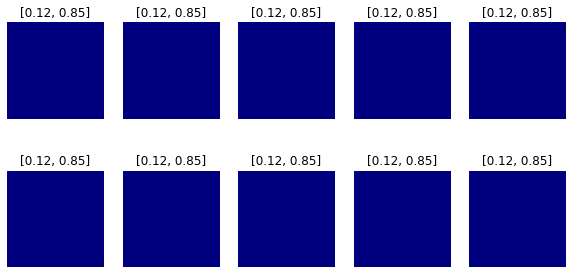

In [79]:
Z = tf.random.uniform(shape=[10, 10])
X = gen(Z)
Y = D(X)
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
k = 0
for i in range(2):
    for j in range(5):
        axs[i, j].imshow(X[k, ..., 0], cmap="jet", vmin=-1, vmax=1)
        axs[i, j].axis("off")
        axs[i, j].set_title(f"[{Y[k, 0]:.2f}, {Y[k, 1]:.2f}]")
        k += 1

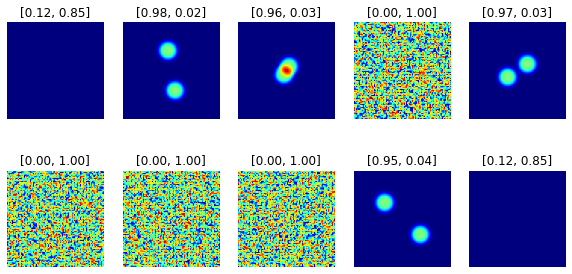

In [78]:
X, Y = dataset[0]
Y = D(X)
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
k = 0
for i in range(2):
    for j in range(5):
        axs[i, j].imshow(X[k, ..., 0], cmap="jet", vmin=-1, vmax=1)
        axs[i, j].axis("off")
        axs[i, j].set_title(f"[{Y[k, 0]:.2f}, {Y[k, 1]:.2f}]")
        k += 1

In [46]:
def critic_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(64, 64, 1)))
    #block 1
    model.add(tf.keras.layers.Conv2D(filters=54, kernel_size=5, strides=2, padding="same"))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization())
    #block 2
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=5, strides=2, padding="same"))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization())
    #block 3
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=5, strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=5, strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization())


    model.add(tf.keras.layers.Reshape((-1,)))
    model.add(tf.keras.layers.Dense(1, activation="tanh")) # score

    return model
critic = critic_model()
critic.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 32, 32, 54)        1404      
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 32, 32, 54)        0         
_________________________________________________________________
batch_normalization_75 (Batc (None, 32, 32, 54)        216       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 16, 16, 128)       172928    
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
batch_normalization_76 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 8, 8, 256)       

In [47]:
class DatasetWgan(tf.keras.utils.Sequence):
    def __init__(self, total_items, batch_size):
        self.total_items = total_items
        self.batch_size = batch_size
        self.indices = tf.range(batch_size)

    def __len__(self):
        return self.total_items // self.batch_size

    def __getitem__(self, idx):
        return self.generate_batch()

    @staticmethod
    def normalize(X, xmin, xmax):
        return 2 * (X - xmin) / (xmax - xmin) - 1 # return x in [-1, 1]

    def generate_batch(self):
        X = CenteredBinaries(self.batch_size//2, 64, width=1).generate_epoch_images()
        X = tf.constant(X, tf.float32)
        xmax = tf.reduce_max(X)
        new_indices = tf.random.shuffle(self.indices)
        X = tf.gather(X, new_indices)
        X = self.normalize(X, 0, xmax)
        return X
batch_size = 50
dataset_wgan = DatasetWgan(1000, batch_size)

In [62]:
def train_wgan(gen, critic, dataset, epochs=100):
    optim_gen = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.9)
    optim_critic = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
    mean_loss = tf.keras.metrics.Mean() # running mean
    # loss_critic = tf.keras.losses.BinaryCrossentropy()
    def sample(batch_size):
        return tf.random.uniform(shape=[batch_size, 10])
    
    def critic_step():
        for X in dataset:
            with tf.GradientTape(watch_accessed_variables=False) as tape:
                tape.watch(critic.trainable_variables)
                Z = sample(batch_size=batch_size)
                X_pred = gen(Z)
                score_fake  = critic(X_pred)
                score_true  = critic(X)
                loss = -score_true + score_fake # Wasserstein loss
            gradients = tape.gradient(loss, critic.trainable_variables)
            gradients = [tf.clip_by_value(grad, -1., 1.) for grad in gradients] # clipping
            optim_critic.apply_gradients(zip(gradients, critic.trainable_variables))

            mean_loss.update_state(loss)

    def gen_step():
        for _ in dataset:
            with tf.GradientTape(watch_accessed_variables=False) as tape:
                tape.watch(gen.trainable_variables)
                Z = sample(batch_size=batch_size)
                X_pred = gen(Z)
                loss   = -critic(X_pred)
            gradients = tape.gradient(loss, gen.trainable_variables)
            gradients = [tf.clip_by_value(grad, -1., 1.) for grad in gradients] # clipping
            optim_gen.apply_gradients(zip(gradients, gen.trainable_variables))

            mean_loss.update_state(loss)

    for epoch in range(epochs):
        mean_loss.reset_states()
        # train discriminator
        if epoch < 2:
            for i in range(2):
                critic_step()
        else:
            for i in range(1):
                critic_step()
        print(f"epoch {epoch} | Discriminator loss = {mean_loss.result():.2e}")

        # train generator
        mean_loss.reset_states()
        if epoch > 2:
            for i in range(2):
                gen_step()
        else:
            for i in range(1):
                gen_step()
        print(f"epoch {epoch} | Generator loss = {mean_loss.result():.2e}")

In [68]:
gen = generator()
critic = critic_model()
train_wgan(gen, critic, dataset_wgan, epochs=5)

epoch 0 | Discriminator loss = -1.58e+00
epoch 0 | Generator loss = 4.01e-01
epoch 1 | Discriminator loss = -1.48e+00
epoch 1 | Generator loss = -3.72e-01
epoch 2 | Discriminator loss = -2.09e-04
epoch 2 | Generator loss = -9.99e-01
epoch 3 | Discriminator loss = -5.34e-03
epoch 3 | Generator loss = 1.00e+00
epoch 4 | Discriminator loss = 0.00e+00
epoch 4 | Generator loss = 1.00e+00


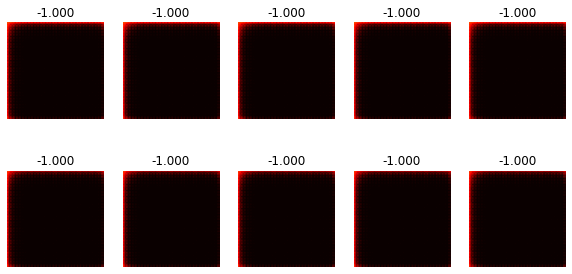

In [69]:
Z = tf.random.uniform(shape=[10, 10])
X = gen(Z)
Y = critic(X)
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
k = 0
for i in range(2):
    for j in range(5):
        axs[i, j].imshow(X[k, ..., 0], cmap="hot", vmin=-1, vmax=1)
        axs[i, j].axis("off")
        axs[i, j].set_title(f"{Y[k].numpy()[0]:.3f}")
        k += 1